In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px

import charset_normalizer
import fuzzywuzzy
from fuzzywuzzy import process
import os
import re
from dateutil import parser

# from scipy import stats
# from tabulate import tabulate
# import sklearn
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.neighbors import NearestNeighbors
# from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
# from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score
# from yellowbrick.cluster import KElbowVisualizer
# from scipy.cluster.hierarchy import dendrogram, linkage

import warnings

warnings.filterwarnings("ignore")
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Character encoding


In [3]:
df_name = []
encoding = []
path = []

dataset_folder = "dataset"
for file in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, file)
    path.append(file_path)
    # look at the first ten thousand bytes to guess the character encoding
    with open(file_path, "rb") as rawdata:
        result = charset_normalizer.detect(rawdata.read())
        encoding.append(result["encoding"])
    # check what the character encoding might be
    file_name = os.path.splitext(file)[0]
    df_name.append(file_name)
    print(f"{file_name}: {result}")

context: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_attr: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_user: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
user: {'encoding': 'utf-8', 'language': 'English', 'confidence': 1.0}


In [4]:
data_source = (tuple(df_name), tuple(encoding), tuple(path))

In [5]:
context = pd.read_csv(data_source[2][0], encoding=data_source[1][0])
context.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
190,2441,Travel,F?ri!%end(s),&Su&&nny,1PM,1,1,0,0,1,0,0
1220,4553,Travel,F?!a!mily,?Su!nny,6 PM,1,0,0,0,1,0,0
2211,17570,Visit,&%?A!lone,&Su&nny,16:00,1,0,0,1,0,0,1
861,12688,Work,!%A lone,Sunny,6:00,1,0,0,1,0,53,1
6813,16641,Visit,%A&?lone,&Sunny,5PM,1,0,0,1,0,8,1


In [6]:
mobile_plan_attr = pd.read_csv(
    data_source[2][1], encoding=data_source[1][1], delimiter=";"
)

mobile_plan_attr.sample(5)

,mobile_plan,description,price,duration
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d
0,DATASILVER,"2GB/ day, high speed",100000,5d
1,DATAGOLD,"5GB/ day, high speed",200000,5d
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d


In [7]:
mobile_plan_user = pd.read_csv(data_source[2][2], encoding=data_source[1][2])
mobile_plan_user.sample(5)

,id,mobile_plan,accept
36444,10442.0,NaN,1.0
23567,13242.0,SOCIALMEDIA,0.0
5934,1229.0,SOCIALMEDIAGOLD,1.0
3590,8268.0,SOCIALMEDIA,1.0
38036,2863.0,DATASILVER,0.0


In [8]:
user = pd.read_csv(data_source[2][3], encoding=data_source[1][3])
user.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
9384,17026,Kenneth Smith,Male,30,Bachelor,Sales & Related,2112500000 VND,S ingle_0,US,853-972-6923x35921,Product manager,0,0,0,0,1
11415,5461,Brenda Johnson,Female,35,Bachelor,Education&Training&Library,627500000 VND,Single_0,US,001-904-658-5007,Ecologist,1,5,1,7,3
7360,13555,Denise Ramirez,Female,73,Associate,Legal,170800$,Ma rried_4,ENGLAND,987.711.8518x422,Government social research officer,0,0,23,7,3
3022,18329,中村 舞,Female,36,Masters,Education&Training&Library,34900$,S ing le_1,JAPAN,080-8025-7605,漫画家,0,4,8,1,1
2277,12968,Dr. Christopher Weeks,Male,43,Masters,Computer & Mathematical,40800$,Married_0,ENGLAND,001-976-913-6822x47764,Operational investment banker,0,0,14,10,7


In [9]:
dataset = [context, mobile_plan_attr, mobile_plan_user, user]

# Cleaning

## Missing values check


In [10]:
for x in dataset:
  print('-----------------')
  print(x.isna().sum())

-----------------
id              0
purpose         0
go_with         0
weather         0
time            0
viettel_no_0    0
viettel_no_1    0
viettel_no_2    0
to_hanoi        0
to_other        0
score           0
direction       0
dtype: int64
-----------------
mobile_plan    0
description    0
price          0
duration       0
dtype: int64
-----------------
id                0
mobile_plan    2715
accept         2721
dtype: int64
-----------------
id                      0
name                    0
gender                  0
age                     0
education            4003
profession              0
income                  0
living_with             0
nation                  0
phone                   0
job                     0
fb_freq                 0
yt_freq                 0
insta_freq              0
use_less_than_2GB       0
use_2GB_to_4GB          0
dtype: int64


In [11]:
mobile_plan_user = mobile_plan_user.dropna(subset=['mobile_plan', 'accept'])

## Context


In [12]:
context.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
9873,9968,Travel,Fa mily,~!Ra!iny,21:00,1,1,0,0,1,8,0
54,2231,Travel,Frie!nd(s),Su?n%ny,9:00,1,1,0,0,1,6,0
6190,8651,Travel,Fri&?end(s),&!S%!unny,8:00,1,0,0,0,1,0,0
1365,2502,Work,A??l&one,Sunny,6AM,1,1,1,0,1,0,0
9567,9468,Visit,Alone,Rainy,19:00,1,0,0,1,0,0,1


In [13]:
for x in ["go_with", "weather"]:
    # Eliminate special characters and white spaces
    context[x] = context[x].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))

    # Lowercase all words
    context[x] = context[x].str.lower()

    print(context[x].unique())

['alone' 'friends' 'fa mily' 'family' 'fami ly' 'a l one' 'fr iends'
 ' alone' 'a lone' '  alone' ' friends' 'f riends' 'f rie nds' 'frie nds'
 'frien ds' 'f amily' ' family' 'alo ne' 'friend s' 'al one' 'fri ends'
 ' a lone' ' fri ends' 'f riend s' 'alon e' 'frien  ds' ' fri e nds'
 'friends ' 'a  lone' 'fa  mily' 'al  one' '   alone' 'fri e nds'
 ' al one' 'fam ily' '  family' 'f rien ds' '  a lone' ' f amily'
 'frie   nds' 'fri en ds' 'f a mily' ' frie nds' 'f  amily' 'fr  iends'
 ' fa mily' 'famil y' ' fr iends' 'fr ie nds' 'fr ien ds' ' f  amily'
 'fam  ily' ' frien ds' 'frie nd s' 'frie n ds' ' friend s' 'frie  nds'
 'fr i ends' 'fri  ends' 'f ri ends' ' a  lone' ' alo ne' 'friend  s'
 'a   lone' '  friends' '   friends' ' fam ily' 'f r iends' 'alo  ne'
 '  a  lone' ' fa  mily' 'f r  iends' 'f  riends' ' frie  nds' 'fri end s'
 ' fami ly' 'f rie  nds' ' f riends' ' al  one' 'f a  mily' ' fa m ily'
 '    alone' 'f  ri ends' 'a lo ne' 'frien d s' 'f am ily' '  f riends'
 '   family

In [14]:
# List of possible values for the column 'go_with'
choices = ["alone", "friend(s)", "family"]


# Apply the fuzzy matching to the column 'go_with'
def correct_name(name):
    return process.extractOne(name, choices)[0]


context["go_with"] = context["go_with"].apply(correct_name)

In [15]:
# Eliminate white spaces
context["time"] = context["time"].str.replace(r"\s+", "", regex=True)


# Function to convert time to 24-hour format
def convert_to_24hr_format(time_str):
    # Use dateutil.parser to parse the time string
    return parser.parse(time_str).strftime("%H:%M")


# Apply the function to the column 'time'
context["time"] = context["time"].apply(convert_to_24hr_format)
context["time"] = pd.to_datetime(context["time"], format="%H:%M").dt.time

In [16]:
context["purpose"] = context["purpose"].str.strip()
context["purpose"] = context["purpose"].str.lower()

In [17]:
context.purpose.unique()

array(['travel', 'visit', 'work'], dtype=object)

In [18]:
context["purpose"] = context["purpose"].replace('travel', 'visit')

In [19]:
context = context.drop(axis=1, columns=["to_hanoi", "to_other"])

In [20]:
context.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,score,direction
6579,14736,visit,friend(s),sunny,17:00:00,1,0,0,5,0
6555,8884,visit,alone,sunny,09:00:00,1,0,0,2,0
5582,11129,visit,alone,rainy,16:00:00,1,1,1,23,0
4317,1370,visit,friend(s),sunny,20:00:00,1,0,0,0,0
10258,9351,work,alone,rainy,06:00:00,1,1,1,9,0


## User


In [21]:
user.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
1448,13370,冯鑫,Female,27,Bachelor,Architecture & Engineering,42300$,Marrie d_2,CHINA,15917549160,百货零售,0,1,2,1,1
2118,10689,Jennifer Mathis,Female,30,Bachelor,Healthcare Practitioners & Technical,2690000000 VND,M arried_0,US,640-932-3287x1304,Technical sales engineer,0,1,1,5,0
8916,19259,Bárbara Barros,Female,27,Highschool,Unemployed,215000000 VND,S ingle_1,BRAZIL,0900-912-1428,Entalhador,0,0,7,3,0
3596,19215,Christopher Bailey,Male,23,NaN,Unemployed,79300$,S in gle_0,ENGLAND,7754034282,Landscape architect,2,5,1,1,0
8489,6444,Luiz Fernando Novaes,Male,25,Highschool,Unemployed,732500000 VND,Sin gle_0,BRAZIL,+55 (061) 4319 6629,Engenheiro de materiais,0,3,7,3,1


In [22]:
# Eliminate white spaces
user["living_with"] = user["living_with"].str.strip()
user["living_with"] = user["living_with"].str.replace(r"\s+", "", regex=True)
user["living_with"] = user["living_with"].str.lower()

In [23]:
user["nation"] = user["nation"].str.strip()
user["nation"] = user["nation"].str.lower()

In [24]:
user["gender"] = user["gender"].str.strip()
user["gender"] = user["gender"].str.lower()

In [25]:
user["education"] = user["education"].str.strip()
user["education"] = user["education"].str.lower()

In [26]:
user.nation.unique()

array(['australia', 'england', 'korea', 'denmark', 'brazil', 'japan',
       'us', 'china', 'russia'], dtype=object)

In [27]:
user["nation"] = user["nation"].replace("australia", "oceania")
user["nation"] = user["nation"].replace(["brazil", "us"], "americas")
user["nation"] = user["nation"].replace(["denmark", "england", "russia"], "europe")
user["nation"] = user["nation"].replace(["korea", "japan", "china"], "asia")

In [28]:
user = user.rename(columns={"nation": "continent"})

In [29]:
user

,id,name,gender,age,education,profession,income,living_with,continent,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
0,11156,Rachel Gibbs,female,21,NaN,Unemployed,39100$,unmarried_2,oceania,(08)-8012-7556,Astronomer,0,0,9,8,3
1,4297,Karen Anderson,other,22,NaN,Unemployed,41000$,unmarried_2,europe,943-646-5203,Air cabin crew,0,0,23,7,2
2,13301,김지원,female,24,NaN,Unemployed,44300$,unmarried_1,asia,010-4500-9888,기계공학 기술자 및 연구원,0,0,23,5,2
3,9920,Elisabeth Wähner,female,24,NaN,Unemployed,44400$,unmarried_1,europe,+49(0) 587406963,Medizininformatiker,0,0,21,7,2
4,8424,Sra. Maria Luiza Nogueira,female,25,NaN,Unemployed,1100000000 VND,unmarried_1,americas,(084) 0568 1445,Ufólogo,0,0,22,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11567,11602,Austin Barber,male,26,bachelor,Sales & Related,82000$,single_0,europe,001-798-297-3345x825,Publishing rights manager,0,0,3,5,3
11568,5645,남상철,male,26,bachelor,Sales & Related,83900$,single_0,asia,043-900-0635,캐드원,0,0,2,4,1
11569,15477,John Blanchard,male,30,bachelor,Sales & Related,76600$,single_0,americas,230-283-6789x89147,"Designer, industrial/product",0,0,3,7,3
11570,8885,Troy Green,male,30,bachelor,Sales & Related,2087500000 VND,single_0,oceania,+61.472.119.694,Patent examiner,0,0,2,7,3


In [30]:
user["education"] = user["education"].fillna("unknown")
user["education"] = user["education"].replace("bachelor", "grad")
user["education"] = user["education"].replace(["associate", "highschool"], "undergrad")
user["education"] = user["education"].replace("masters", "postgrad")

In [31]:
user.profession.unique()

array(['Unemployed', 'Architecture & Engineering', 'Student',
       'Education&Training&Library', 'Healthcare Support',
       'Healthcare Practitioners & Technical', 'Sales & Related',
       'Management', 'Arts Design Entertainment Sports & Media',
       'Computer & Mathematical', 'Life Physical Social Science',
       'Personal Care & Service', 'Community & Social Services',
       'Office & Administrative Support', 'Construction & Extraction',
       'Legal', 'Retired', 'Installation Maintenance & Repair',
       'Transportation & Material Moving', 'Business & Financial',
       'Protective Service', 'Food Preparation & Serving Related',
       'Production Occupations',
       'Building & Grounds Cleaning & Maintenance',
       'Farming Fishing & Forestry'], dtype=object)

In [32]:
user.living_with.unique()

array(['unmarried_2', 'unmarried_1', 'single_0', 'married_1', 'married_2',
       'married_4', 'married_3', 'unmarried_0', 'single_2', 'single_1',
       'single_4', 'single_3', 'divorced_2', 'divorced_1', 'divorced_3',
       'married_0', 'unmarried_4', 'divorced_4', 'widowed_0',
       'unmarried_3', 'widowed_4', 'widowed_1', 'widowed_3', 'widowed_2',
       'divorced_0'], dtype=object)

In [33]:
# Seperate Living_With column into Maritual_Status column and Children column
user[["marital_status", "children"]] = user["living_with"].str.split("_", expand=True)


user["marital_status"] = user["marital_status"].apply(
    lambda x: "relationship" if x == "married" else "single"
)

## mobile_plan_attr


In [34]:
mobile_plan_attr.head()

,mobile_plan,description,price,duration
0,DATASILVER,"2GB/ day, high speed",100000,5d
1,DATAGOLD,"5GB/ day, high speed",200000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d


In [35]:
mobile_plan_attr['mobile_plan'] = mobile_plan_attr['mobile_plan'].str.lower()

In [36]:
mobile_plan_attr['duration'] = mobile_plan_attr['duration'].str.replace('d', '')

In [37]:
mobile_plan_attr['capacity'] = mobile_plan_attr['description'].str.extract(r'(\d+)GB')

In [38]:
mobile_plan_attr.head()

,mobile_plan,description,price,duration,capacity
0,datasilver,"2GB/ day, high speed",100000,5,2
1,datagold,"5GB/ day, high speed",200000,5,5
2,socialmedia,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3,1
3,socialmediagold,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3,3
4,datacall,"2GB/ day, high speed\n300 mins call for extern...",200000,5,2


## mobile_plan_user


In [39]:
mobile_plan_user.head()

,id,mobile_plan,accept
0,11156.0,DATASILVER,1.0
1,4297.0,SOCIALMEDIAGOLD,1.0
2,13301.0,DATASILVER,1.0
3,9920.0,SOCIALMEDIAGOLD,1.0
4,8424.0,DATASILVER,1.0


In [40]:
mobile_plan_user['mobile_plan'] = mobile_plan_user['mobile_plan'].str.lower()

In [41]:
mobile_planes = mobile_plan_user.mobile_plan.unique()

### Mobile plan acceptance


In [42]:
# Sử dụng pivot_table để tổng hợp dữ liệu
mobile_plan_accept = mobile_plan_user.pivot_table(
    index="id", columns="mobile_plan", values="accept", aggfunc="sum", fill_value=0
).reset_index()

# Đảm bảo tất cả các cột trong mobile_planes có mặt trong bảng kết quả cuối cùng
for plan in mobile_planes:
    if plan not in mobile_plan_accept.columns:
        mobile_plan_accept[plan] = 0

# Sắp xếp lại các cột theo thứ tự trong mobile_planes
mobile_plan_accept = mobile_plan_accept[["id"] + list(mobile_planes)]

In [43]:
mobile_plan_accept

mobile_plan,id,datasilver,socialmediagold,socialmedia,datacall,datagold
0,1000.0,1.0,0.0,0.0,0.0,0.0
1,1001.0,0.0,0.0,1.0,0.0,0.0
2,1002.0,0.0,1.0,0.0,0.0,0.0
3,1004.0,0.0,0.0,0.0,0.0,0.0
4,1005.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
11567,19994.0,0.0,0.0,0.0,0.0,0.0
11568,19996.0,0.0,0.0,0.0,1.0,0.0
11569,19997.0,1.0,0.0,0.0,0.0,0.0
11570,19998.0,0.0,0.0,0.0,0.0,0.0


### Mobile plan recommendation


In [44]:
mobile_plan_rec_raw = mobile_plan_user[["id"]]

# Create columns for each item in the mobile_plan_user dataframe
for item in mobile_planes:
    mobile_plan_rec_raw[item] = mobile_plan_user["mobile_plan"].apply(
        lambda x: 1 if x == item else np.nan
    )

# Check rows that have duplicated ID
duplicate_rows = mobile_plan_rec_raw[
    mobile_plan_rec_raw.duplicated(subset=["id"], keep=False)
]
# Sort by ID
duplicate_rows.sort_values("id")

# Fill missing values of each ID group
# In each ID group, each missing value will be replaced by the last valid value forward (ffill), otherwise, by the next valid value backward (bfill).
mobile_plan_rec = duplicate_rows.groupby("id").apply(
    lambda x: x.fillna(method="ffill").fillna(method="bfill")
)
mobile_plan_rec = mobile_plan_rec.drop_duplicates()

mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="id").reset_index()
mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="level_1")

mobile_plan_rec = mobile_plan_rec.fillna(0)
mobile_plan_rec

,id,datasilver,socialmediagold,socialmedia,datacall,datagold
0,1000.0,1.0,0.0,1.0,1.0,0.0
1,1001.0,0.0,0.0,1.0,1.0,0.0
2,1005.0,0.0,0.0,1.0,1.0,1.0
3,1006.0,0.0,0.0,1.0,1.0,0.0
4,1008.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
10107,19992.0,0.0,1.0,1.0,1.0,0.0
10108,19996.0,0.0,1.0,1.0,1.0,1.0
10109,19997.0,1.0,1.0,0.0,0.0,1.0
10110,19998.0,1.0,1.0,1.0,0.0,0.0


# Data type check


In [45]:
dataset = [context, mobile_plan_attr, mobile_plan_accept, mobile_plan_rec, user]
for x in dataset:
    print("-------------------------")
    print(x.dtypes)

-------------------------
id               int64
purpose         object
go_with         object
weather         object
time            object
viettel_no_0     int64
viettel_no_1     int64
viettel_no_2     int64
score            int64
direction        int64
dtype: object
-------------------------
mobile_plan    object
description    object
price           int64
duration       object
capacity       object
dtype: object
-------------------------
mobile_plan
id                 float64
datasilver         float64
socialmediagold    float64
socialmedia        float64
datacall           float64
datagold           float64
dtype: object
-------------------------
id                 float64
datasilver         float64
socialmediagold    float64
socialmedia        float64
datacall           float64
datagold           float64
dtype: object
-------------------------
id                    int64
name                 object
gender               object
age                   int64
education            objec

In [46]:
context.time = pd.to_datetime(context.time, format="%H:%M:%S").dt.time


mobile_plan_attr.duration = mobile_plan_attr.duration.astype(int)
mobile_plan_attr.capacity = mobile_plan_attr.capacity.astype(int)


mobile_plan_accept.id = mobile_plan_accept.id.astype(int)
mobile_plan_accept.datasilver = mobile_plan_accept.datasilver.astype(int)
mobile_plan_accept.socialmediagold = mobile_plan_accept.socialmediagold.astype(int)
mobile_plan_accept.socialmedia = mobile_plan_accept.socialmedia.astype(int)
mobile_plan_accept.datacall = mobile_plan_accept.datacall.astype(int)
mobile_plan_accept.datagold = mobile_plan_accept.datagold.astype(int)


mobile_plan_rec.id = mobile_plan_rec.id.astype(int)
mobile_plan_rec.datasilver = mobile_plan_rec.datasilver.astype(int)
mobile_plan_rec.socialmediagold = mobile_plan_rec.socialmediagold.astype(int)
mobile_plan_rec.socialmedia = mobile_plan_rec.socialmedia.astype(int)
mobile_plan_rec.datacall = mobile_plan_rec.datacall.astype(int)
mobile_plan_rec.datagold = mobile_plan_rec.datagold.astype(int)


user.children = user.children.astype(int)

In [47]:
df = (
  user.merge(context, on="id", how="left")
  .merge(mobile_plan_accept, on="id", how="left", suffixes=("", "_acc"))
  .merge(mobile_plan_rec, on="id", how="left", suffixes=("", "_rec"))
)
df.head()

,id,name,gender,age,education,profession,income,living_with,continent,phone,...,datasilver,socialmediagold,socialmedia,datacall,datagold,datasilver_rec,socialmediagold_rec,socialmedia_rec,datacall_rec,datagold_rec
0,11156,Rachel Gibbs,female,21,unknown,Unemployed,39100$,unmarried_2,oceania,(08)-8012-7556,...,1,0,0,0,0,1.0,0.0,0.0,0.0,1.0
1,4297,Karen Anderson,other,22,unknown,Unemployed,41000$,unmarried_2,europe,943-646-5203,...,0,1,0,0,0,0.0,1.0,0.0,1.0,1.0
2,13301,김지원,female,24,unknown,Unemployed,44300$,unmarried_1,asia,010-4500-9888,...,1,0,0,0,0,1.0,0.0,0.0,1.0,1.0
3,9920,Elisabeth Wähner,female,24,unknown,Unemployed,44400$,unmarried_1,europe,+49(0) 587406963,...,0,1,0,0,0,1.0,1.0,0.0,0.0,0.0
4,8424,Sra. Maria Luiza Nogueira,female,25,unknown,Unemployed,1100000000 VND,unmarried_1,americas,(084) 0568 1445,...,1,0,0,0,0,1.0,0.0,1.0,0.0,0.0


In [48]:
df.columns

Index(['id', 'name', 'gender', 'age', 'education', 'profession', 'income',
       'living_with', 'continent', 'phone', 'job', 'fb_freq', 'yt_freq',
       'insta_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'marital_status',
       'children', 'purpose', 'go_with', 'weather', 'time', 'viettel_no_0',
       'viettel_no_1', 'viettel_no_2', 'score', 'direction', 'datasilver',
       'socialmediagold', 'socialmedia', 'datacall', 'datagold',
       'datasilver_rec', 'socialmediagold_rec', 'socialmedia_rec',
       'datacall_rec', 'datagold_rec'],
      dtype='object')

In [49]:
df = df[['gender', 'age', 'education', 'profession', 'income',
       'living_with', 'continent',
       
       'fb_freq', 'yt_freq', 'insta_freq', 'use_less_than_2GB', 'use_2GB_to_4GB',
       
       'marital_status', 'children', 'purpose', 'go_with', 'weather', 'time',
       
       'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'score', 'direction',
       
       'datasilver', 'datagold', 'socialmedia', 'socialmediagold', 'datacall',
       
       'datasilver_rec', 'datagold_rec', 'socialmedia_rec', 'socialmediagold_rec', 'datacall_rec']]

In [50]:
df

,gender,age,education,profession,income,living_with,continent,fb_freq,yt_freq,insta_freq,...,datasilver,datagold,socialmedia,socialmediagold,datacall,datasilver_rec,datagold_rec,socialmedia_rec,socialmediagold_rec,datacall_rec
0,female,21,unknown,Unemployed,39100$,unmarried_2,oceania,0,0,9,...,1,0,0,0,0,1.0,1.0,0.0,0.0,0.0
1,other,22,unknown,Unemployed,41000$,unmarried_2,europe,0,0,23,...,0,0,0,1,0,0.0,1.0,0.0,1.0,1.0
2,female,24,unknown,Unemployed,44300$,unmarried_1,asia,0,0,23,...,1,0,0,0,0,1.0,1.0,0.0,0.0,1.0
3,female,24,unknown,Unemployed,44400$,unmarried_1,europe,0,0,21,...,0,0,0,1,0,1.0,0.0,0.0,1.0,0.0
4,female,25,unknown,Unemployed,1100000000 VND,unmarried_1,americas,0,0,22,...,1,0,0,0,0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11567,male,26,grad,Sales & Related,82000$,single_0,europe,0,0,3,...,0,0,1,0,0,0.0,1.0,1.0,1.0,1.0
11568,male,26,grad,Sales & Related,83900$,single_0,asia,0,0,2,...,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0
11569,male,30,grad,Sales & Related,76600$,single_0,americas,0,0,3,...,0,0,0,0,0,0.0,0.0,1.0,1.0,0.0
11570,male,30,grad,Sales & Related,2087500000 VND,single_0,oceania,0,0,2,...,0,0,0,0,0,0.0,0.0,1.0,0.0,1.0


In [51]:
labels = ['datasilver_rec', 'datagold_rec', 'socialmedia_rec', 'socialmediagold_rec', 'datacall_rec']

In [52]:
features = df.drop(axis=1, columns=labels)

In [53]:
#Check categorical variables
check = (features.dtypes == 'object')
object_columns = list(check[check].index)

object_columns

['gender',
 'education',
 'profession',
 'income',
 'living_with',
 'continent',
 'marital_status',
 'purpose',
 'go_with',
 'weather',
 'time']

## Đơn biến

In [56]:
class EDA:
    
    def row(self,data):
        # Display the number of rows and columns in the dataframe
        fig = make_subplots(rows=1, cols=2)
        fig.add_trace(go.Indicator(mode = "number", value = data.shape[0], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "🧾 Rows<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0, 0.5], 'y': [0.6, 1]}))
        fig.add_trace(go.Indicator(mode = "number", value = data.shape[1], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "⭕ Columns<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0.5, 1], 'y': [0, 0.4]}))
        fig.show()
    
    def border_msg(self,msg, indent=1, width=None, title=None):
        """Print message-box with optional title."""
        lines = msg.split('\n')
        space = " " * indent
        if not width:
            width = max(map(len, lines))
        box = f'╔{"═" * (width + indent * 2)}╗\n'  
        if title:
            box += f'║{space}{title:<{width}}{space}║\n'  
            box += f'║{space}{"-" * len(title):<{width}}{space}║\n'  
        box += ''.join([f'║{space}{line:<{width}}{space}║\n' for line in lines])
        box += f'╚{"═" * (width + indent * 2)}╝' 
        print('\033[92m'+'\033[1m')
        print(box)
        
    def distribution(self,x,title):
        # Plot the distribution of a numerical column
        plt.figure(figsize=(10,8))
        ax = sns.distplot(x, kde=False,bins=30)
        values = np.array([rec.get_height() for rec in ax.patches])
        norm = plt.Normalize(values.min(), values.max())
        colors = plt.cm.jet(norm(values))
        for rec, col in zip(ax.patches,colors):
            rec.set_color(col)
        plt.title(title, size=20, color='black')
        
    def run(self,df):
        
        self.row(df)
        if len(df)>0:
            
            object_df = df.select_dtypes('object').columns.tolist()
            int_df = df.select_dtypes('int').columns.tolist()
            bool_df = df.select_dtypes('bool').columns.tolist()
            float_df = df.select_dtypes('float').columns.tolist()

            if len(object_df)>0:
                
                print( '\033[1m'+"OBJECT TYPE")
                for col in object_df:
                    # Display information about object type columns
                    self.border_msg(' '*25+ col.upper() + ' '*25)
                    self.border_msg('There are {} unique values in {} column'.format(df[col].nunique(),col.upper()))
                    plt.figure(figsize=(10,5))
                    sns.countplot(y = col, data = df,
                                  order = df[col].value_counts().index)
                    plt.show()
                    
            if len(int_df)>0:
                
                print('\033[1m'+"INT TYPE")
                for col in int_df:
                    # Display information about integer type columns
                    self.border_msg(' '*25+ col.upper() + ' '*25)
                    self.border_msg('Average value is : {}'.format(df[col].mean()))
                    self.border_msg('Minumum value is : {}'.format(df[col].min()))
                    self.border_msg('Maximum value is : {}'.format(df[col].max()))
                    self.distribution(df[col],title=col)
                    if df[col].mean()>df[col].std():
                        print(self.border_msg("Normal distributed Data Located below mean"))
                        
                    elif df[col].mean()<df[col].std():
                        print(self.border_msg("Normal distributed Data Located above mean"))
                    else:
                        self.border_msg("Mean Equals Std Dev - Distribution is normal")
                        
                    fig = make_subplots(rows=1, cols=2)
                    fig.add_trace(go.Indicator(mode = "number", value = df[col].mean(), number={'font':{'color': '#E58F65','size':100}}, title = {"text": "📌 Mean<br><span style='font-size:0.8em;color:gray'></span>"}, domain = {'x': [0, 0.5], 'y': [0.6, 1]}))
                    fig.add_trace(go.Indicator(mode = "number", value = df[col].std(), number={'font':{'color': '#E58F65','size':100}}, title = {"text": "🖇 Standart dev<br><span style='font-size:0.8em;color:gray'></span>"}, domain = {'x': [0.5, 1], 'y': [0, 0.4]}))
                    fig.show()
                    plt.show()
                 

            if len(bool_df)>0:
                
                print('\033[1m'+"BOOL TYPE")
                for col in bool_df:
                    # Display information about boolean type columns
                    self.border_msg(' '*25+ col.upper() + ' '*25)
                    plt.figure(figsize=(10,5))
                    sns.countplot(y = col, data = df,
                                  order = df[col].value_counts().index)
                    plt.show()
                    
            if len(float_df)>0:
                
                print('\033[1m'+"FLOAT TYPE")
                for col in float_df:
                    # Display information about float type columns
                    for col in int_df:
                        self.distribution(df[col],title=col)
                        if df[col].mean()>df[col].std():
                            print(self.border_msg("Normal distributed Data Located below mean"))
                        
                        elif df[col].mean()<df[col].std():
                            print(self.border_msg("Normal distributed Data Located above mean"))
                        else:
                            self.border_msg("Mean Equals Std Dev - Distribution is normal")

OBJECT TYPE

╔══════════════════════════════════════════════════════════╗
║                          GENDER                          ║
╚══════════════════════════════════════════════════════════╝

╔════════════════════════════════════════════╗
║ There are 3 unique values in GENDER column ║
╚════════════════════════════════════════════╝


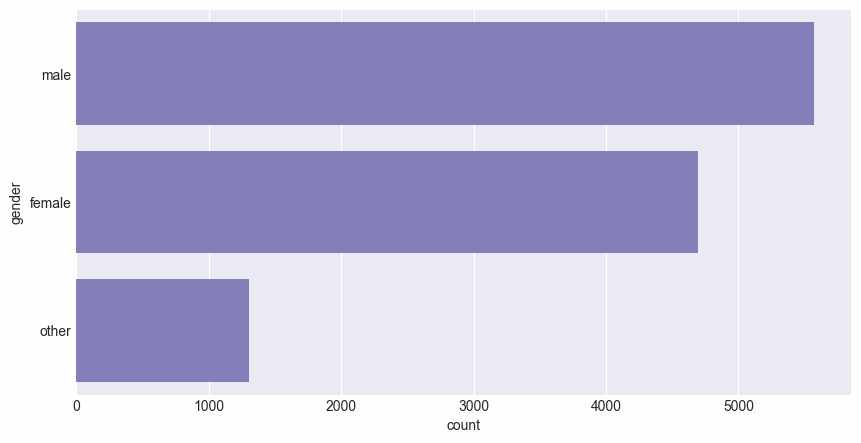


╔═════════════════════════════════════════════════════════════╗
║                          EDUCATION                          ║
╚═════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════╗
║ There are 4 unique values in EDUCATION column ║
╚═══════════════════════════════════════════════╝


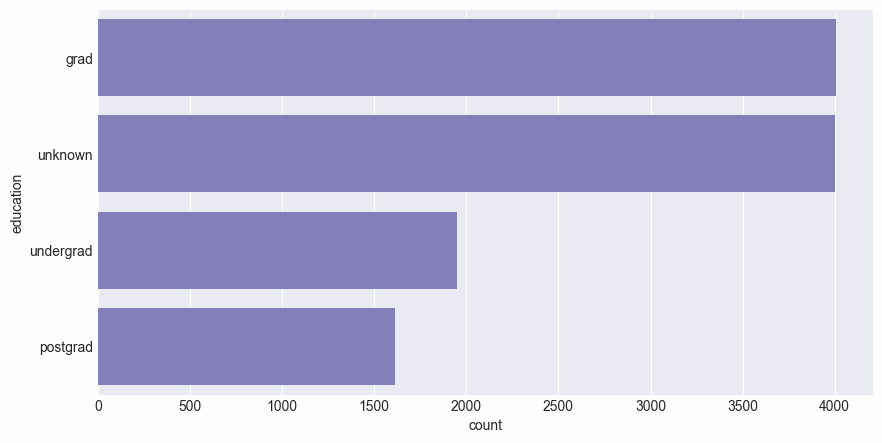


╔══════════════════════════════════════════════════════════════╗
║                          PROFESSION                          ║
╚══════════════════════════════════════════════════════════════╝

╔═════════════════════════════════════════════════╗
║ There are 25 unique values in PROFESSION column ║
╚═════════════════════════════════════════════════╝


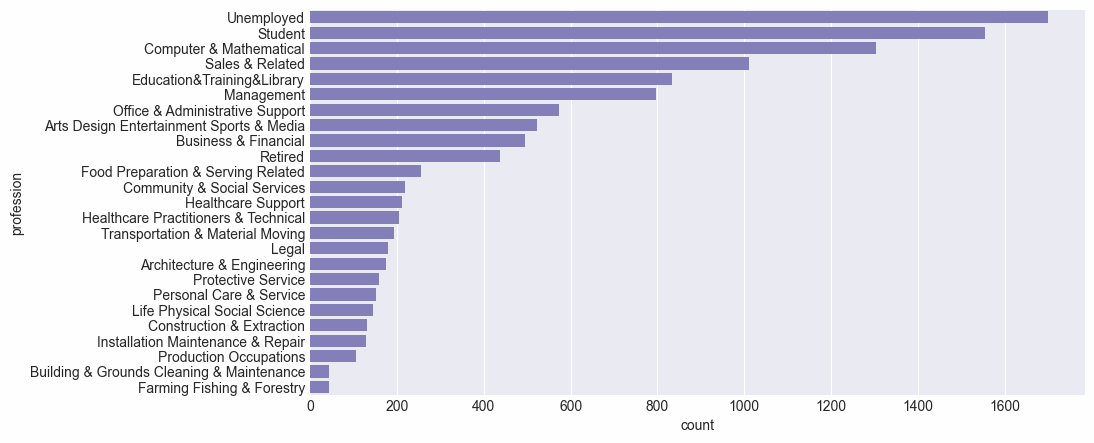


╔══════════════════════════════════════════════════════════╗
║                          INCOME                          ║
╚══════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════╗
║ There are 3394 unique values in INCOME column ║
╚═══════════════════════════════════════════════╝


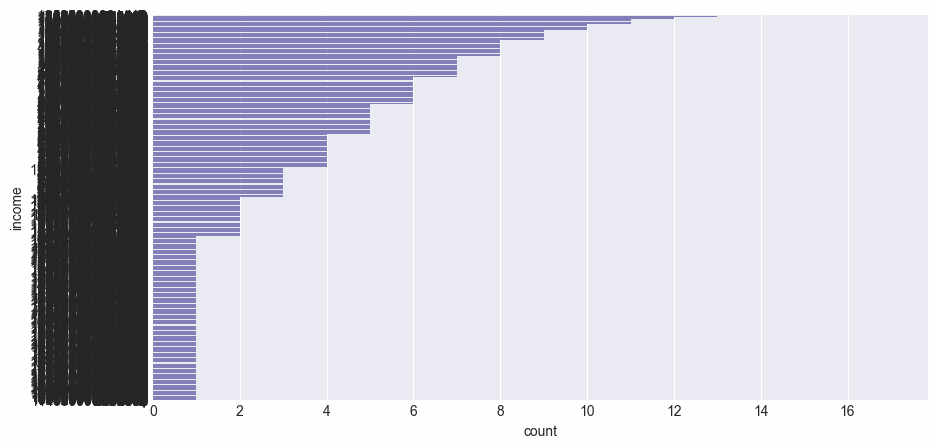


╔═══════════════════════════════════════════════════════════════╗
║                          LIVING_WITH                          ║
╚═══════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════╗
║ There are 25 unique values in LIVING_WITH column ║
╚══════════════════════════════════════════════════╝


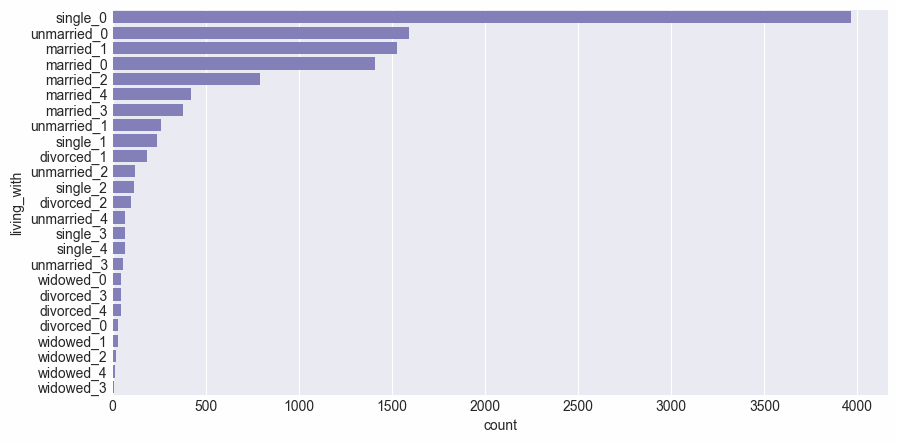


╔═════════════════════════════════════════════════════════════╗
║                          CONTINENT                          ║
╚═════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════╗
║ There are 4 unique values in CONTINENT column ║
╚═══════════════════════════════════════════════╝


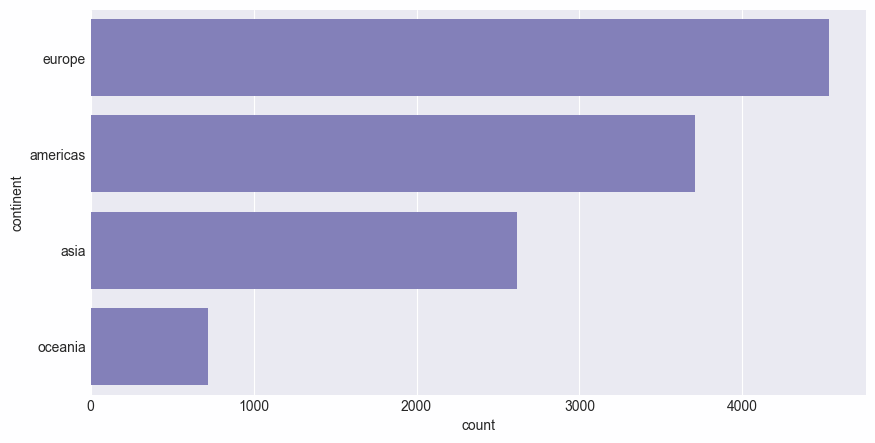


╔══════════════════════════════════════════════════════════════════╗
║                          MARITAL_STATUS                          ║
╚══════════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════════════════╗
║ There are 2 unique values in MARITAL_STATUS column ║
╚════════════════════════════════════════════════════╝


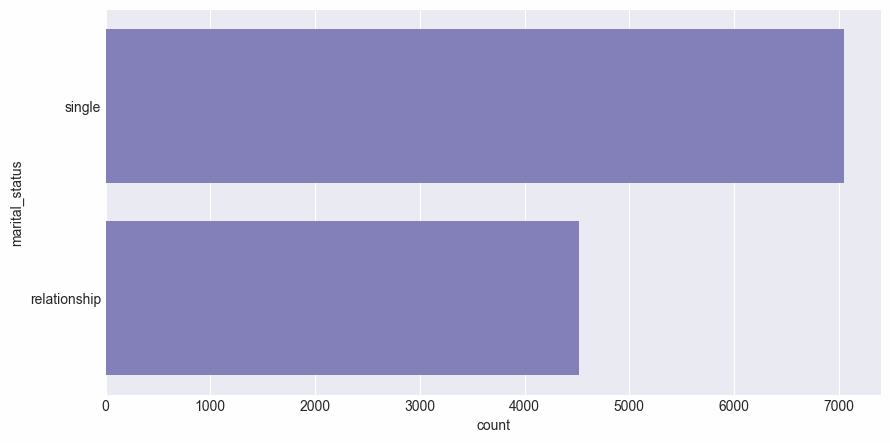


╔═══════════════════════════════════════════════════════════╗
║                          PURPOSE                          ║
╚═══════════════════════════════════════════════════════════╝

╔═════════════════════════════════════════════╗
║ There are 2 unique values in PURPOSE column ║
╚═════════════════════════════════════════════╝


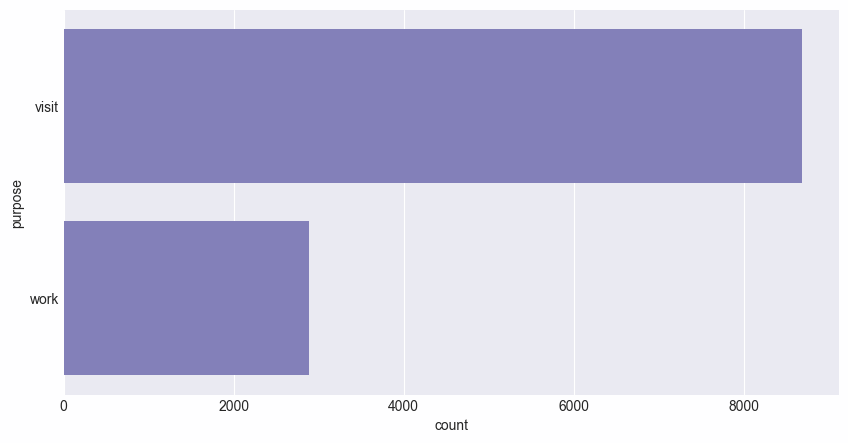


╔═══════════════════════════════════════════════════════════╗
║                          GO_WITH                          ║
╚═══════════════════════════════════════════════════════════╝

╔═════════════════════════════════════════════╗
║ There are 3 unique values in GO_WITH column ║
╚═════════════════════════════════════════════╝


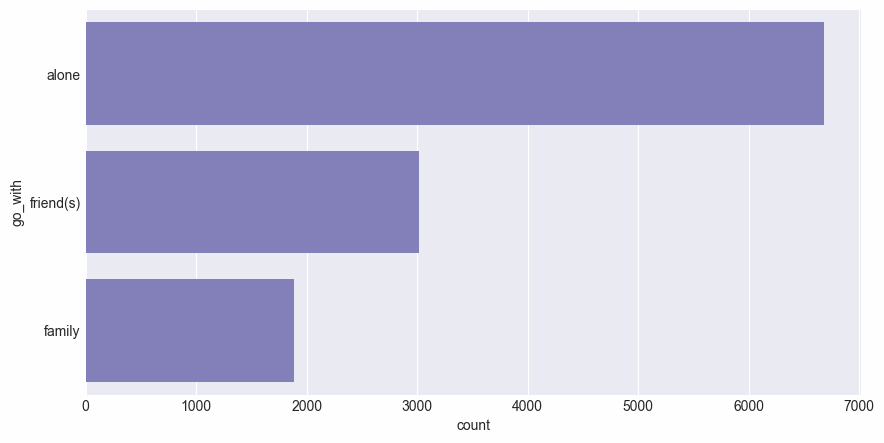


╔═══════════════════════════════════════════════════════════╗
║                          WEATHER                          ║
╚═══════════════════════════════════════════════════════════╝

╔═════════════════════════════════════════════╗
║ There are 3 unique values in WEATHER column ║
╚═════════════════════════════════════════════╝


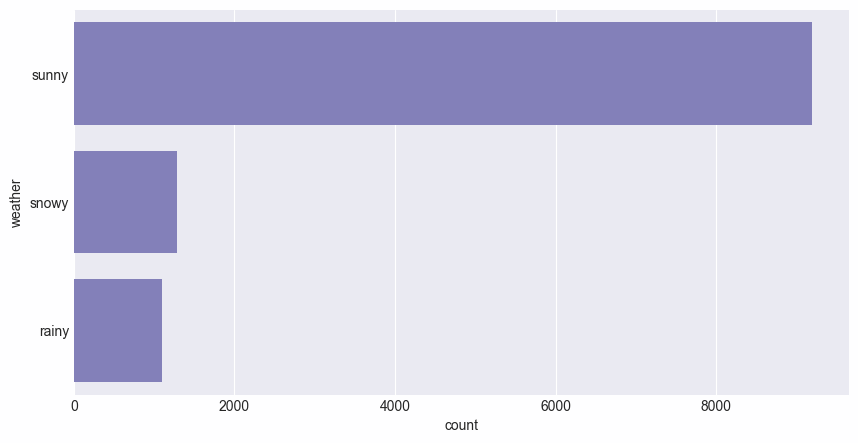


╔════════════════════════════════════════════════════════╗
║                          TIME                          ║
╚════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════╗
║ There are 18 unique values in TIME column ║
╚═══════════════════════════════════════════╝


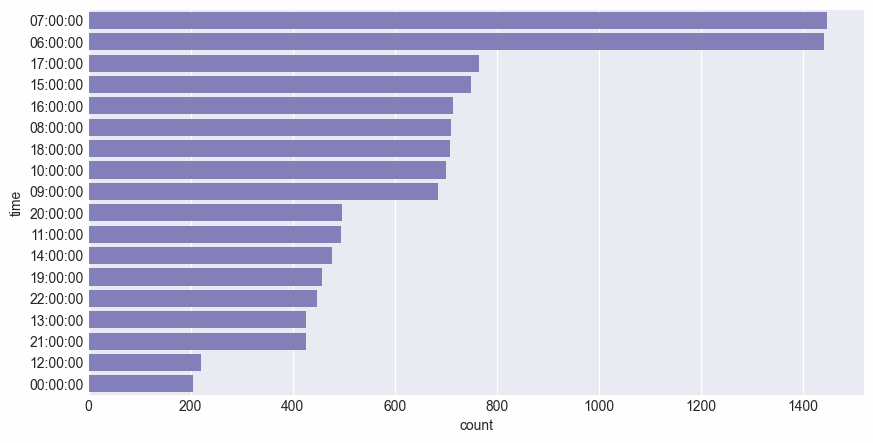

INT TYPE

╔═══════════════════════════════════════════════════════╗
║                          AGE                          ║
╚═══════════════════════════════════════════════════════╝

╔══════════════════════════════════════╗
║ Average value is : 34.89336329070169 ║
╚══════════════════════════════════════╝

╔═══════════════════════╗
║ Minumum value is : 18 ║
╚═══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 79 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located below mean ║
╚════════════════════════════════════════════╝
None


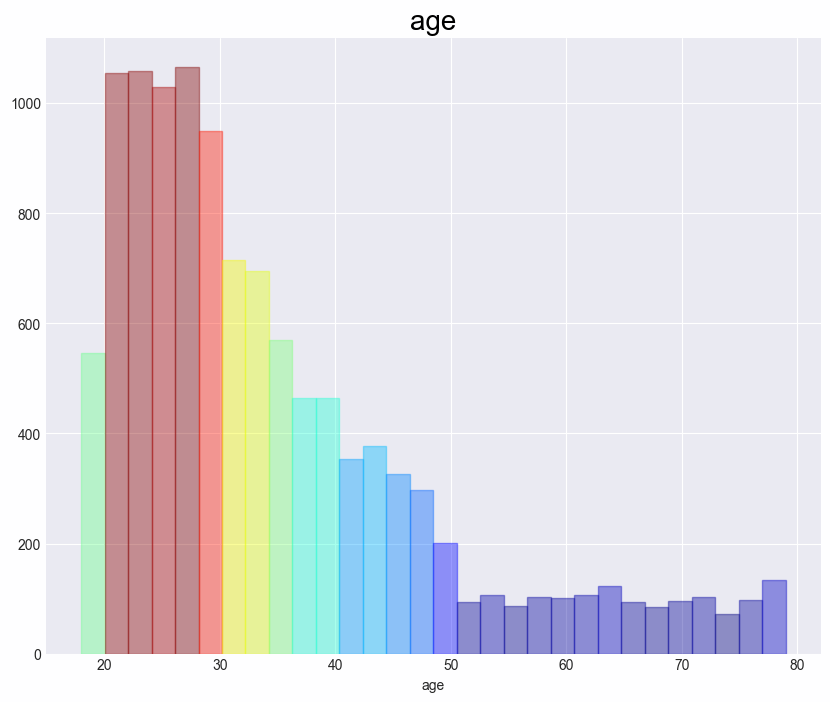


╔═══════════════════════════════════════════════════════════╗
║                          FB_FREQ                          ║
╚═══════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 1.6600414794331144 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 23 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


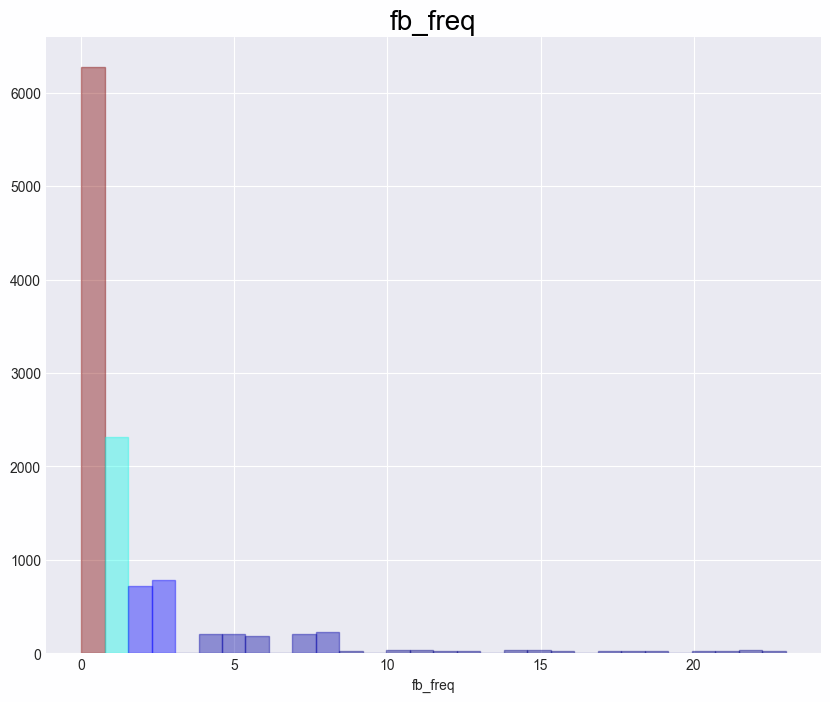


╔═══════════════════════════════════════════════════════════╗
║                          YT_FREQ                          ║
╚═══════════════════════════════════════════════════════════╝

╔══════════════════════════════════════╗
║ Average value is : 3.184929139301763 ║
╚══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 23 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


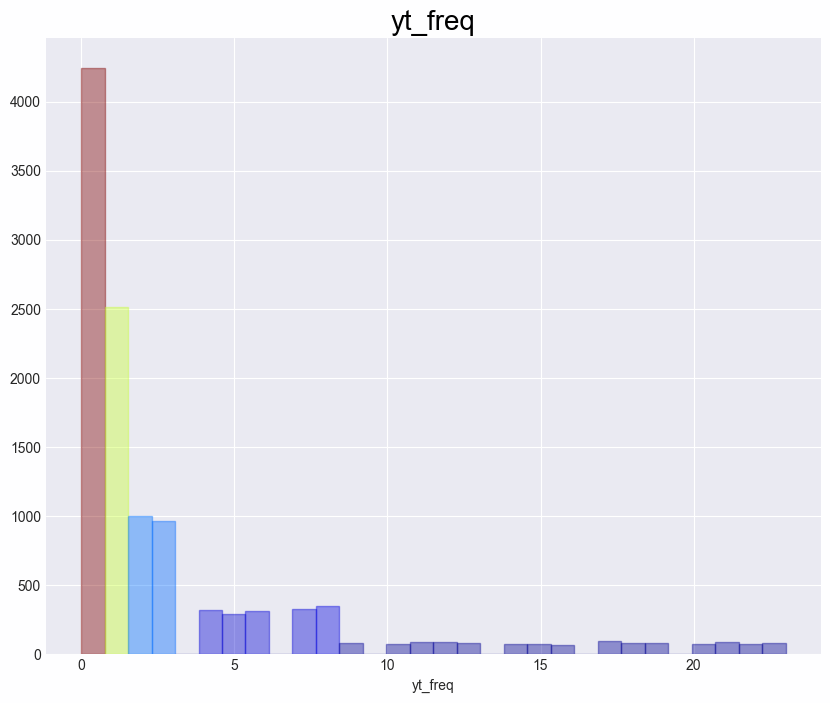


╔══════════════════════════════════════════════════════════════╗
║                          INSTA_FREQ                          ║
╚══════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════╗
║ Average value is : 5.008382302108537 ║
╚══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 23 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


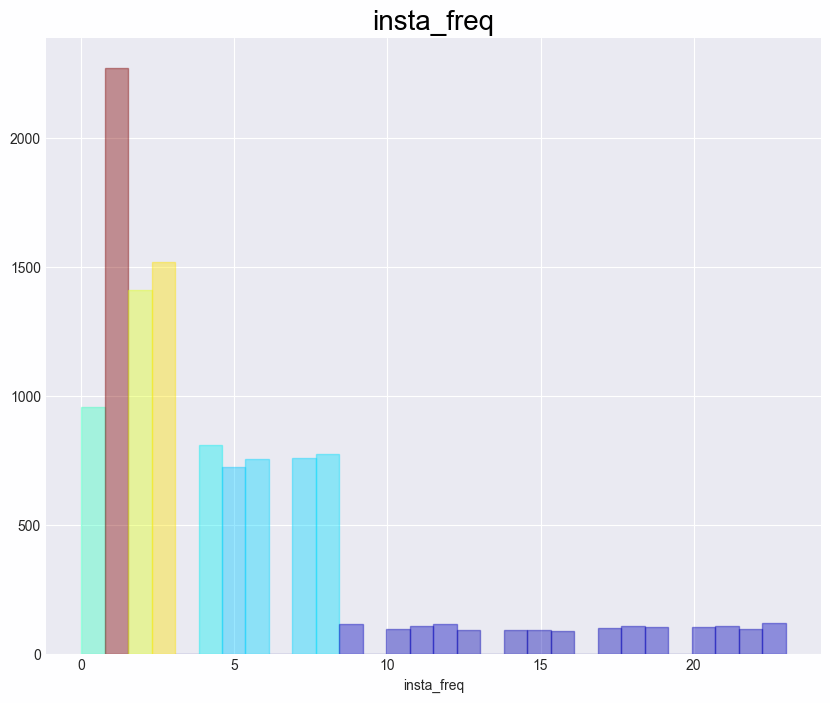


╔═════════════════════════════════════════════════════════════════════╗
║                          USE_LESS_THAN_2GB                          ║
╚═════════════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════╗
║ Average value is : 4.411251296232285 ║
╚══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 23 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


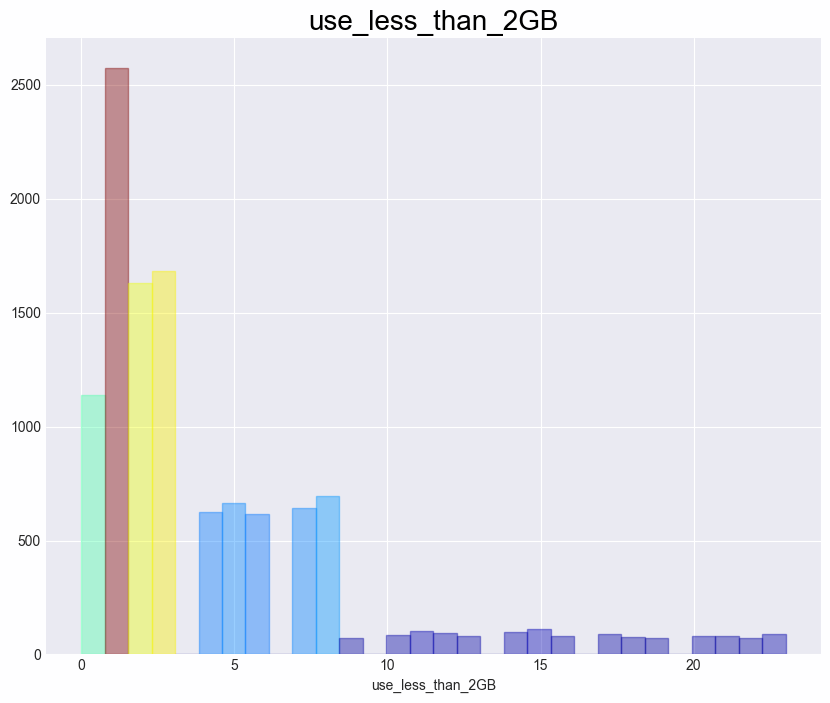


╔══════════════════════════════════════════════════════════════════╗
║                          USE_2GB_TO_4GB                          ║
╚══════════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════╗
║ Average value is : 1.703335637746284 ║
╚══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 23 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


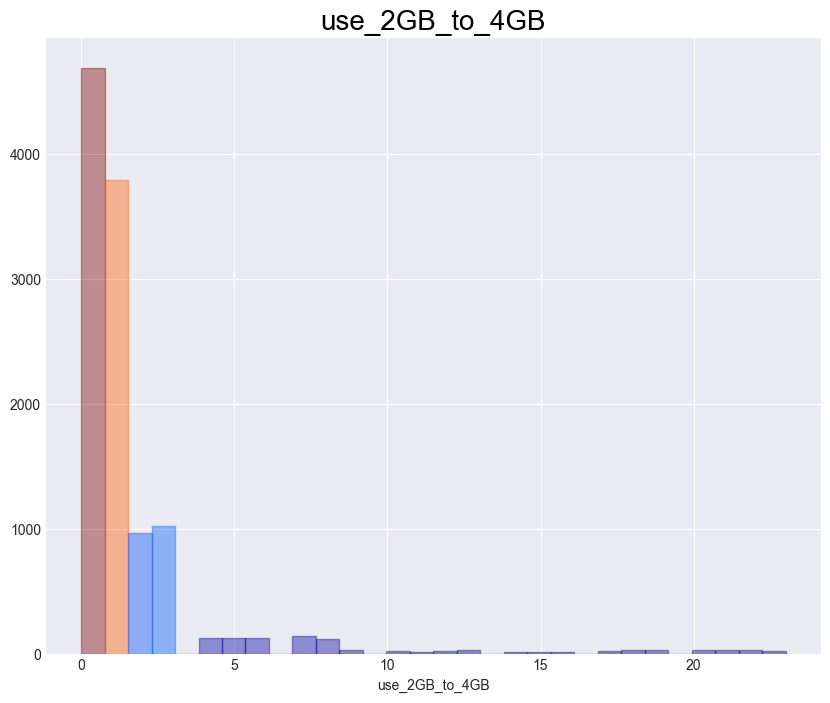


╔════════════════════════════════════════════════════════════╗
║                          CHILDREN                          ║
╚════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 0.7421361908053923 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 4 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


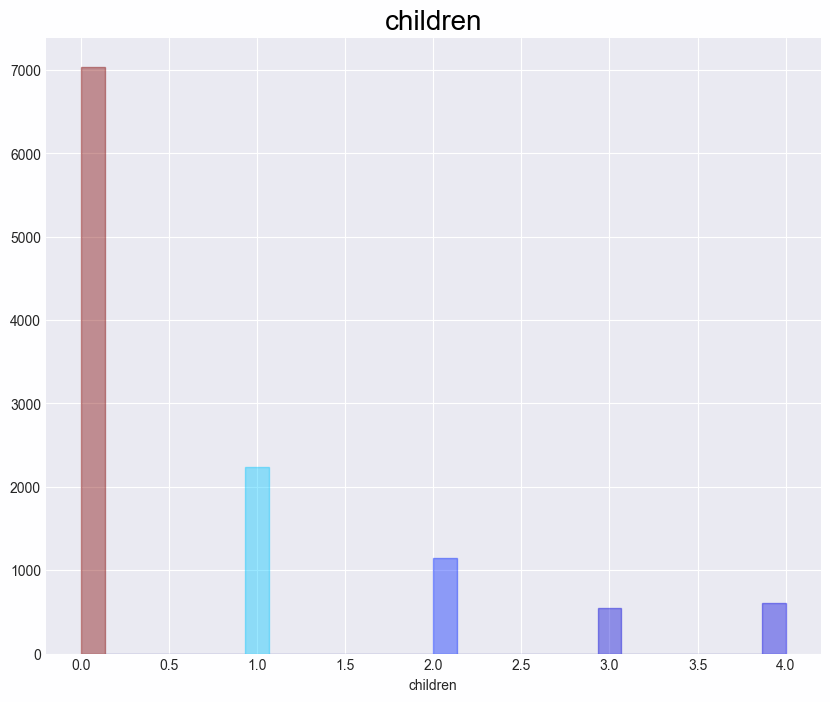


╔════════════════════════════════════════════════════════════════╗
║                          VIETTEL_NO_0                          ║
╚════════════════════════════════════════════════════════════════╝

╔════════════════════════╗
║ Average value is : 1.0 ║
╚════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 1 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located below mean ║
╚════════════════════════════════════════════╝
None


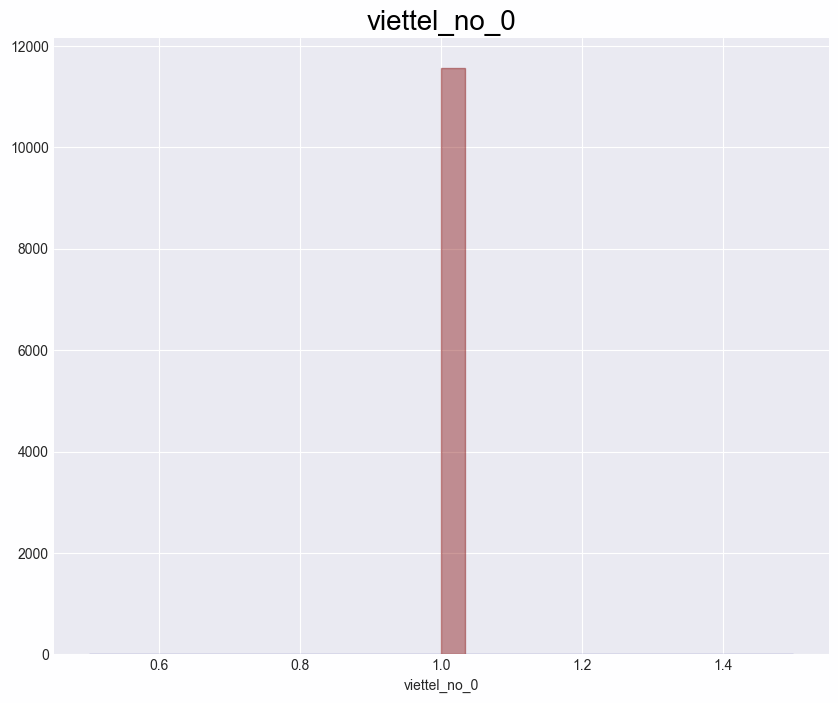


╔════════════════════════════════════════════════════════════════╗
║                          VIETTEL_NO_1                          ║
╚════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 0.5599723470445904 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located below mean ║
╚════════════════════════════════════════════╝
None


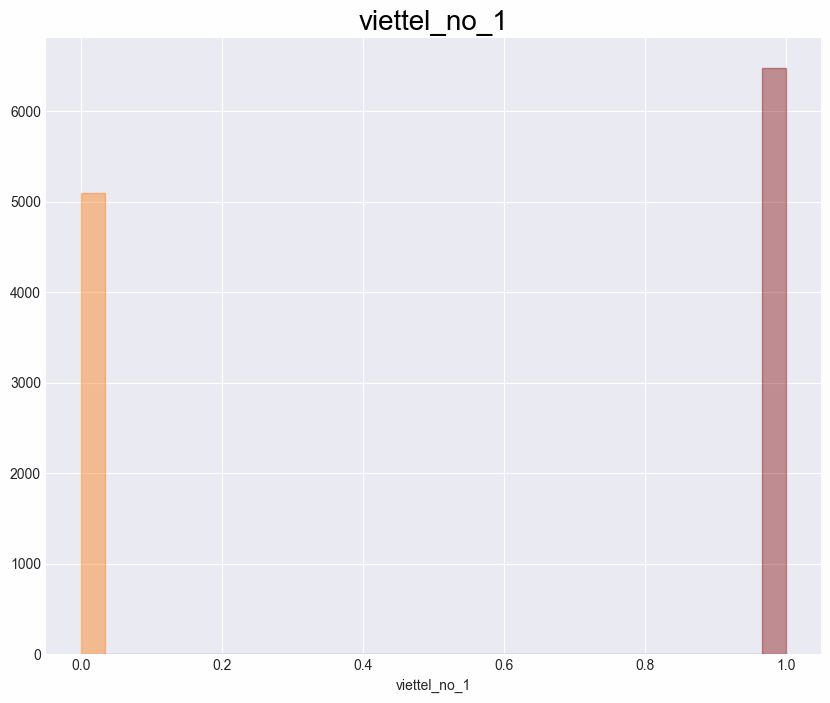


╔════════════════════════════════════════════════════════════════╗
║                          VIETTEL_NO_2                          ║
╚════════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════╗
║ Average value is : 0.11830279986173522 ║
╚════════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


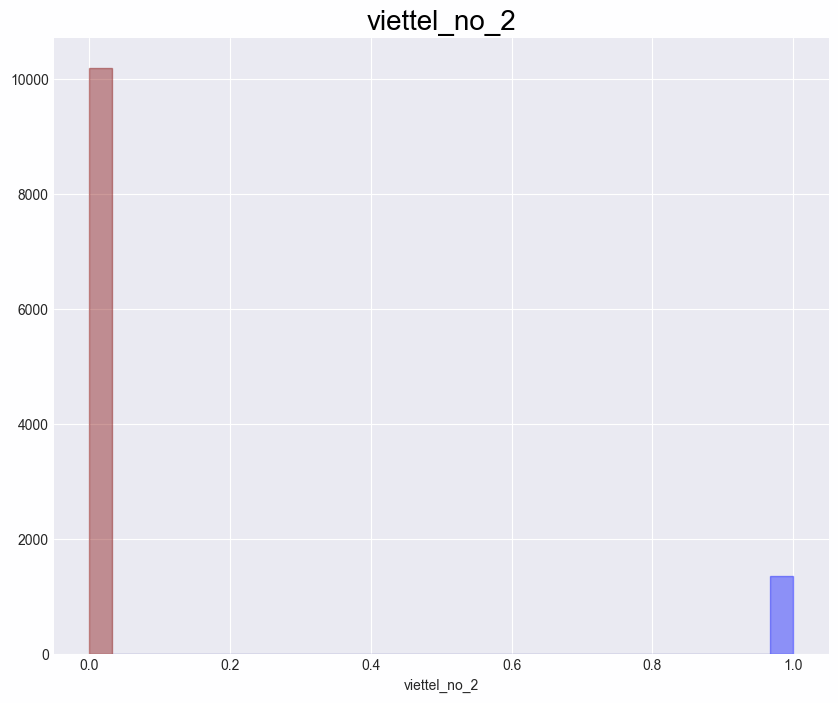


╔═════════════════════════════════════════════════════════╗
║                          SCORE                          ║
╚═════════════════════════════════════════════════════════╝

╔══════════════════════════════════════╗
║ Average value is : 5.297528517110266 ║
╚══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔════════════════════════╗
║ Maximum value is : 105 ║
╚════════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


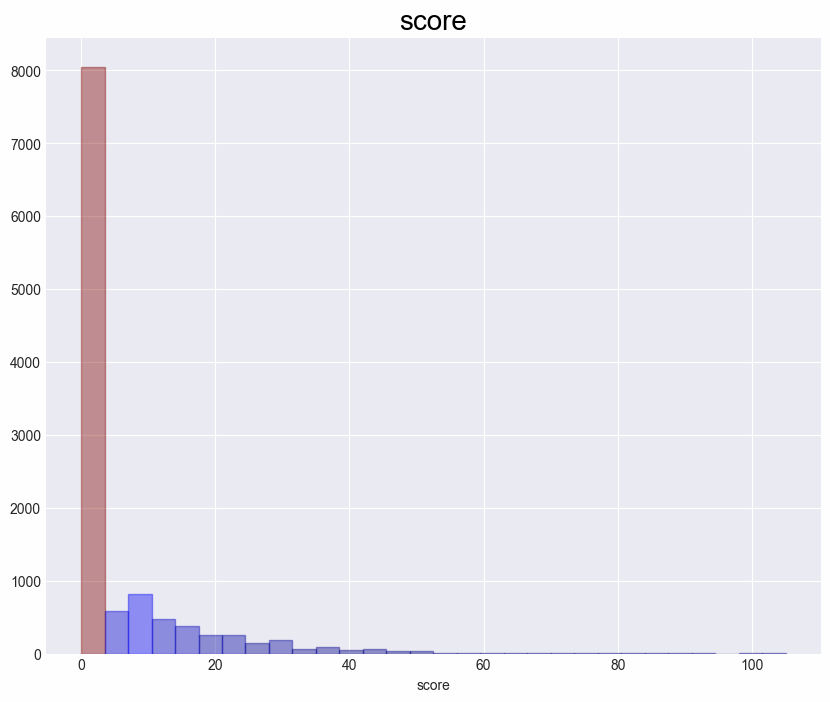


╔═════════════════════════════════════════════════════════════╗
║                          DIRECTION                          ║
╚═════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 0.2153473902523332 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


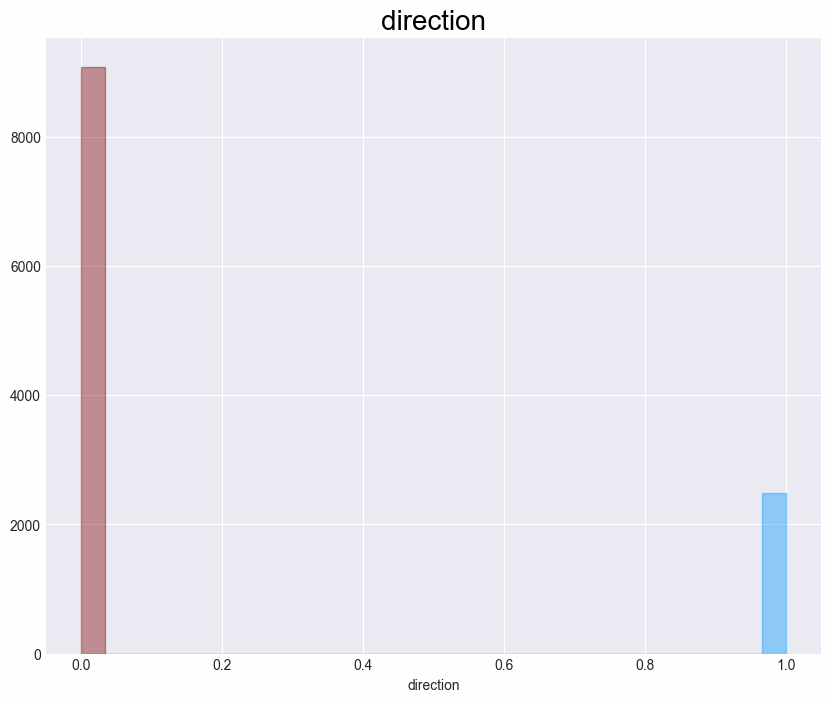


╔══════════════════════════════════════════════════════════════╗
║                          DATASILVER                          ║
╚══════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════╗
║ Average value is : 0.16073280331835466 ║
╚════════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 5 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


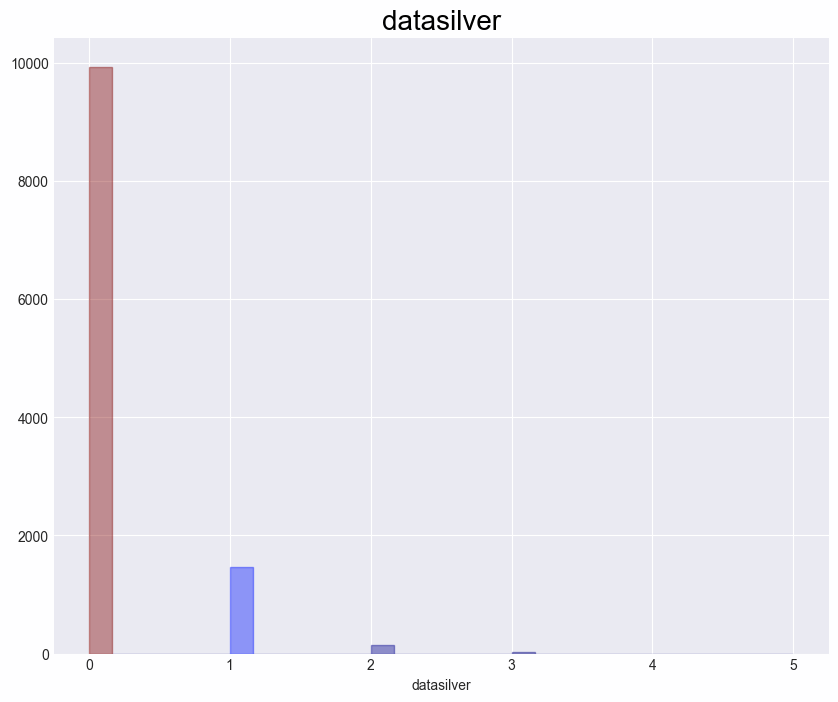


╔════════════════════════════════════════════════════════════╗
║                          DATAGOLD                          ║
╚════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════╗
║ Average value is : 0.07077428275146906 ║
╚════════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 4 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


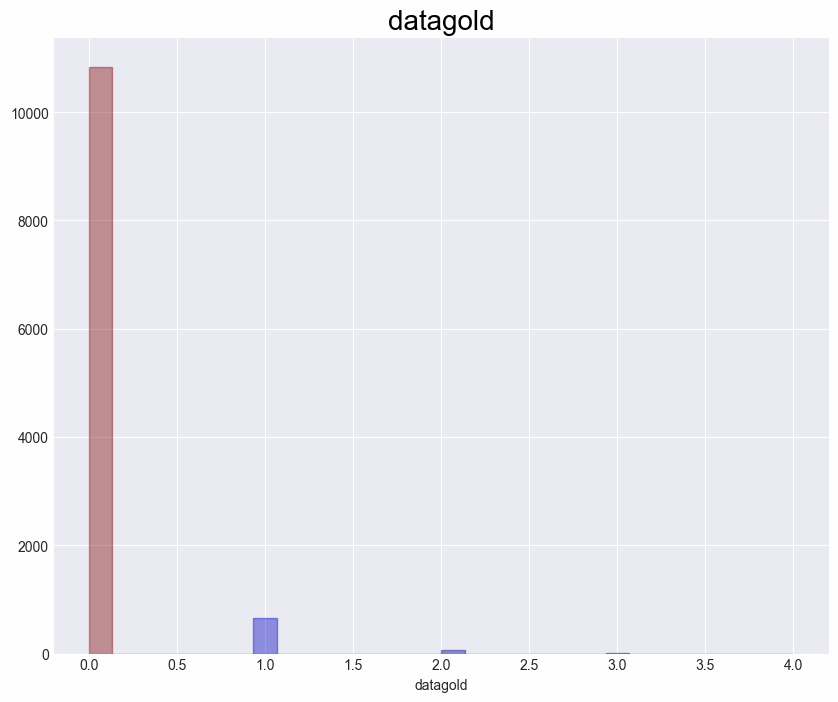


╔═══════════════════════════════════════════════════════════════╗
║                          SOCIALMEDIA                          ║
╚═══════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════╗
║ Average value is : 0.16609056342896647 ║
╚════════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 3 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


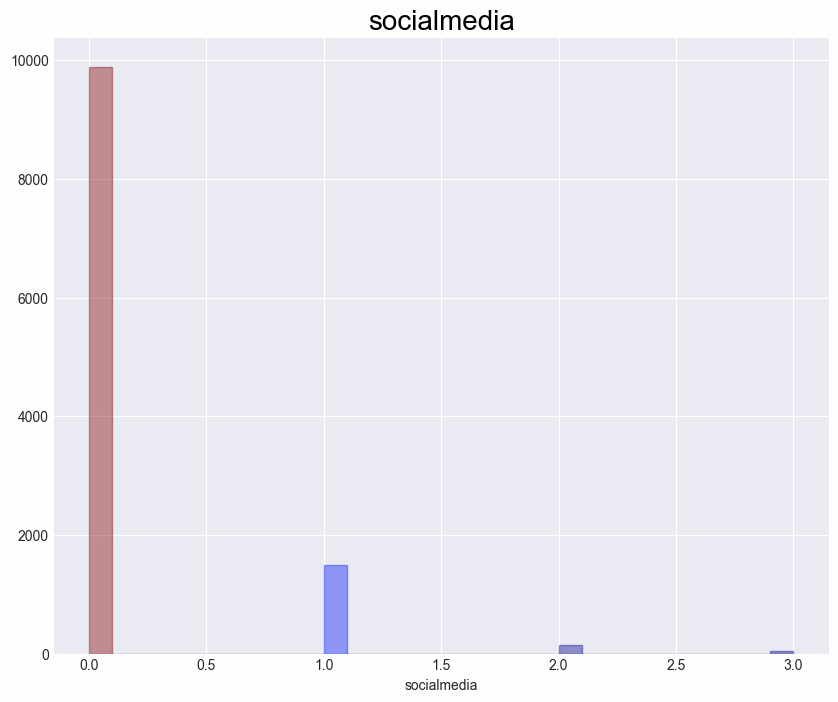


╔═══════════════════════════════════════════════════════════════════╗
║                          SOCIALMEDIAGOLD                          ║
╚═══════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 0.1447459384721742 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 3 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


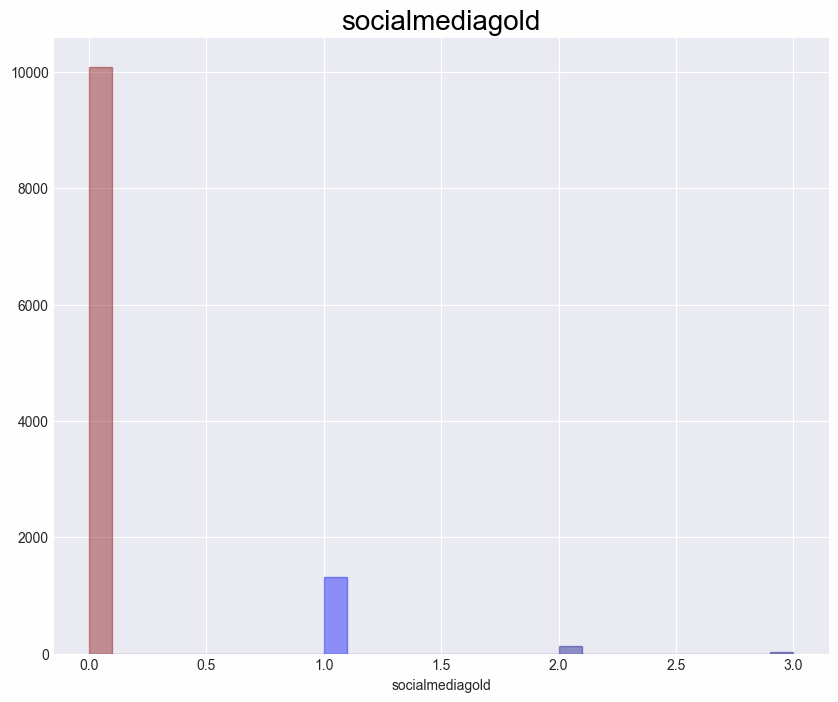


╔════════════════════════════════════════════════════════════╗
║                          DATACALL                          ║
╚════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 0.0844279294849637 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 4 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


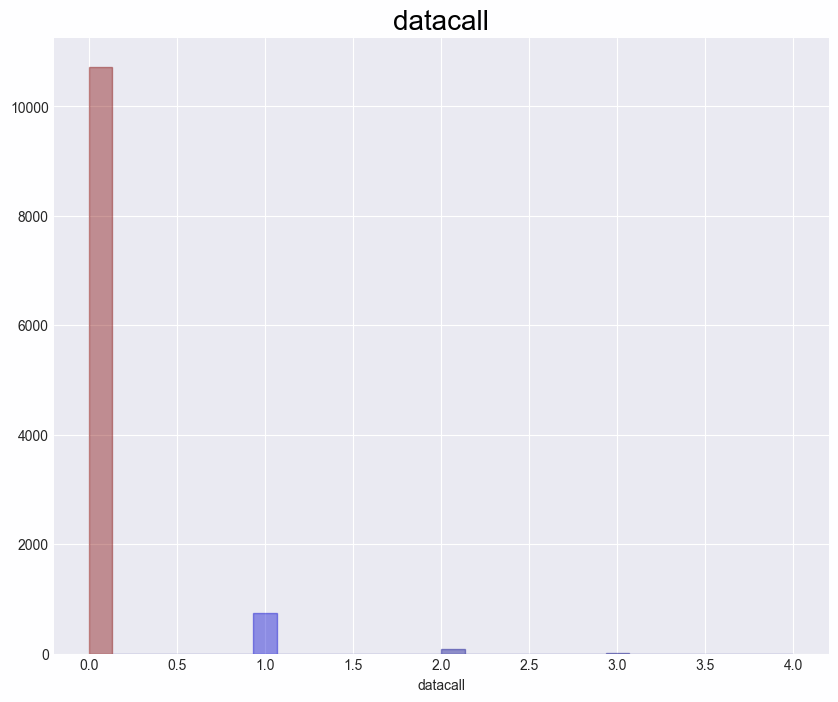

In [57]:
frame = EDA().run(features)